<a href="https://colab.research.google.com/github/santiagorg2401/tensorflow_course_exercises/blob/main/07_skimlit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit Project
NLP or sequence project, many to one since we're going to classify text sequences into 5 classes.

This project replicates the PubMed 200k RCT architecture.

## Solve importations

In [1]:
import os
import string
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from keras.utils import plot_model
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from helper_functions import calculate_results
from HelperFunctions import ModelHelperFunctions as MHF

tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
print(f"TensorFlow version: {tf.__version__}")
print(f"Physical GPUs: {physical_devices}")

2023-08-05 08:44:27.895255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 08:44:28.619792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.1
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-05 08:44:30.242866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 08:44:30.359643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 08:44:30.359827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Preprocess data

### Load in data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct/

/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
dev.txt  test.txt  train.txt
/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
dev.txt  test.txt  train.txt


!!! Dev is the same as valdiation set.

In [4]:
DATA_DIR  = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

filenames = [DATA_DIR + filename for filename in os.listdir(DATA_DIR)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [5]:
# Create a function to parse the text file lines
def get_lines(filename):
  """
  Reads filename and returns its lines as a list.

  Args:
    filename: Str containing the target filepath

  Returns:
    A list of strings with one string per line from the target file.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [6]:
# Read in the training lines.
train_lines = get_lines(DATA_DIR + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

In [8]:
# Format the data.
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries containing the formated data with the items
  line_number, target, text and total_lines.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  # Parse the required information for each line in input lines.
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_lines_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_lines_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(DATA_DIR + 'train.txt')
val_samples = preprocess_text_with_line_numbers(DATA_DIR + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(DATA_DIR + 'test.txt')
print(len(train_lines), len(val_samples), len(test_samples))

210040 30212 30135
CPU times: user 219 ms, sys: 27.2 ms, total: 246 ms
Wall time: 247 ms


In [10]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
# Turn the data into a DataFrame for better data visualization
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

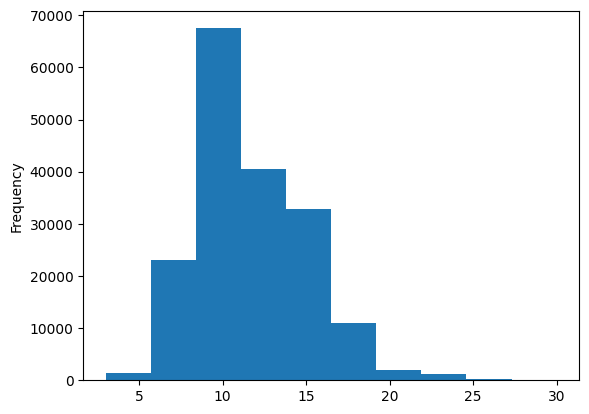

In [13]:
train_df.total_lines.plot.hist()

In [14]:
# Convert text lines into lists.
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentencess = test_df["text"].tolist()

### Encode labels

In [15]:
# Make numeric labels one hot encoding the data.
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/home/santiagorg2401/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
# Label encode labels, extract labels and encode them from text into integers.
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get class names and number of classes from LabelEncoder.
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Vectorization and embedding

avg_sent_len:  26.338269273494777
max_len:  296
output_seq_len:  55


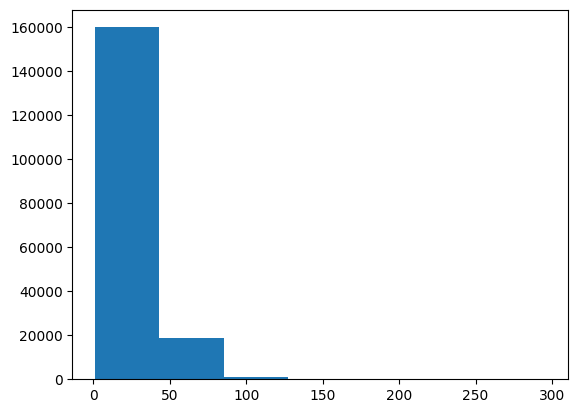

In [18]:
# Average sentence length
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
print("avg_sent_len: ", avg_sent_len)

# Max sequence length
print("max_len: ", max(sent_lens))

# Plot distribution
plt.hist(sent_lens, bins=7)

# Get 95th percentile of the distribution.
output_seq_len = int(np.percentile(sent_lens, 95))
print("output_seq_len: ", output_seq_len)

In [19]:
# Vocabulary size taken from original paper.
max_tokens = 68000

# Create text vectorizer
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                           output_sequence_length=output_seq_len)

# Adapt text vectorizer to training sentences.
text_vectorizer.adapt(train_sentences)

# Test it out.
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"Vectorized text: {text_vectorizer([target_sentence])}")

2023-08-05 08:44:32.267179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 08:44:32.267351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 08:44:32.267464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Text:
the time for successful intubation was the primary outcome .

Length of text: 10
Vectorized text: [[  2  63  11 845 847  10   2  56  86   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [20]:
# Explore the vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[:-5]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment', 'is', 'after', 'by', 'this', 'groups', 'as', 'an', 'from', 'that', 'randomized', 'between', 'not', 'trial', 'no', 'compared', 'control', 'be', 'significant', 'intervention', 'significantly', 'n', 'months', 'than', 'we', 'vs', 'rsb', 'lsb', 'clinical', 'placebo', 'baseline', 'ci', 'two', 'during', 'weeks', 'both', 'had', 'primary', 'mean', 'are', 'using', 'participants', 'there', 'all', 'time', 'years', 'pain', 'therapy', 'who', 'mg', 'more', 'effect', 'effects', 'but', 'risk', 'difference', 'outcomes', 'total', 'care', 'rate', 'efficacy', 'received', 'associated', 'higher', 'respectively', 'days', 'analysis', 'outcome', 'use', 'one', 'week', 'women', 'may', 'randomly', 'levels', 'followup', 'will', 'increased', 'health',

### Prepare the dataset using the Dataset TF API

In [21]:
# Create Dataset instances.
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentencess, test_labels_one_hot))

train_dataset, valid_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [22]:
# Prefetch datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, valid_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## `model_0` Baseline Naives Bayes Classifier

### Create the model

In [23]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the model.
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Make predictions

In [24]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

### Evaluate the model

In [25]:
model_0_eval = model_0.score(X=val_sentences,
              y=val_labels_encoded)
model_0_eval

0.7218323844829869

In [26]:
model_0_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## `model_1` Conv1D with token embeddings

### Create token embeddings

In [27]:
# Create an embedding layer
EMBEDDING_DIM = 128
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=EMBEDDING_DIM,
                               mask_zero=True,
                               name="token_embedding")

# Test it out.
print(f"Sentence before vectorization:\n{target_sentence}")
print(f"Sentence after vectorization:\n{text_vectorizer([target_sentence])}")
print(f"Sentence after embedding:\n{token_embed(text_vectorizer([target_sentence]))}")

Sentence before vectorization:
the time for successful intubation was the primary outcome .
Sentence after vectorization:
[[  2  63  11 845 847  10   2  56  86   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
Sentence after embedding:
[[[ 6.5535083e-03  4.5494769e-02 -3.4254447e-02 ...  3.4028776e-03
    1.4667299e-02  3.3082996e-02]
  [ 3.4099486e-02  3.2900605e-02 -3.8339354e-02 ...  4.9492348e-02
    4.5477498e-02 -2.9515997e-03]
  [ 1.0572396e-02  4.0676031e-02  2.0169131e-03 ... -4.5834638e-02
   -1.8369406e-05  3.2903899e-02]
  ...
  [ 1.6272571e-02 -3.0721819e-02 -8.8839605e-04 ...  2.4081495e-02
    3.5213996e-02  1.8836048e-02]
  [ 1.6272571e-02 -3.0721819e-02 -8.8839605e-04 ...  2.4081495e-02
    3.5213996e-02  1.8836048e-02]
  [ 1.6272571e-02 -3.0721819e-02 -8.8839605e-04 ...  2.4081495e-02
    3.5213996e-02  1.8836048e-02]]]


### Create the model

In [28]:
# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x) # 5 Different tokens at a time.
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1")
model_1_MHF = MHF(img_shape=None, model=model_1, class_names=[])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # Only train on 10% of dataset, otherwise it would take too long. The time between experiments should be around 5 mins.
                              epochs = 3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

model_1.summary()

Epoch 1/3


2023-08-05 08:44:40.843824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180040,5]
	 [[{{node Placeholder/_1}}]]
2023-08-05 08:44:41.281140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-05 08:44:41.587446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-05 08:44:41.613045: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f282400d1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-05 08:44:41.613070: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capabil

562/562 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.6335

2023-08-05 08:45:02.103283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [30212,5]
	 [[{{node Placeholder/_1}}]]


562/562 [==============================] - 22s 36ms/step - loss: 0.9188 - accuracy: 0.6335 - val_loss: 0.6865 - val_accuracy: 0.7370
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6622 - accuracy: 0.7531 - val_loss: 0.6350 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.6227 - accuracy: 0.7709 - val_loss: 0.6021 - val_accuracy: 0.7812
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                        

### Make predictions

In [29]:
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)

model_1_preds_probs, model_1_preds

945/945 [==============================] - 1s 1ms/step


(array([[4.08850998e-01, 1.58323735e-01, 1.08750544e-01, 2.97339112e-01,
         2.67356299e-02],
        [4.73253459e-01, 2.64433891e-01, 1.14475507e-02, 2.44850561e-01,
         6.01458270e-03],
        [1.60750076e-01, 1.12176463e-02, 1.82410574e-03, 8.26179504e-01,
         2.86740269e-05],
        ...,
        [3.18958701e-06, 6.43736043e-04, 5.65346854e-04, 2.46968648e-06,
         9.98785317e-01],
        [5.28498739e-02, 4.80460197e-01, 1.08264416e-01, 6.88365772e-02,
         2.89588898e-01],
        [1.74435645e-01, 6.26884639e-01, 3.26086208e-02, 5.71624413e-02,
         1.08908601e-01]], dtype=float32),
 <tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>)

### Evaluate the model

In [30]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 1s 1ms/step - loss: 0.6060 - accuracy: 0.7830


[0.6059759259223938, 0.7830332517623901]

In [31]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.30332318284125,
 'precision': 0.7804472147769655,
 'recall': 0.7830332318284126,
 'f1': 0.7806682326412129}

## `model_2` NLP Feature extraction with pretrained token embeddings
Universal Sentence Encoder from TF Hub: https://tfhub.dev/google/universal-sentence-encoder/4

In [32]:
# Download pretrained TF Hub USE
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [33]:
# Test USE on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"USE embedding sentence:\n{use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
patients will be randomised to either group using a web-based system .


2023-08-05 08:45:52.099157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


USE embedding sentence:
[-0.03443167  0.02785549 -0.04372675  0.01973596 -0.0459892  -0.01012335
  0.01500829 -0.00267248 -0.06142299  0.00418576  0.10305233  0.0108436
  0.07130036  0.03990951 -0.03080055  0.05664785 -0.09744251 -0.06216166
 -0.09524249  0.0795683   0.01316499  0.02722847 -0.02032232 -0.04153914
 -0.01645784 -0.00566693 -0.04768697  0.03747419  0.03600257 -0.0034307 ]
Length of sentence embedding: 512


### Create the model

In [34]:
# Create the model
inputs = layers.Input(shape=[], dtype=tf.string, name="input_layer")
x = tf_hub_embedding_layer(inputs) # Tokenize and embedd
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name = "model_2")
model_2_MHF = MHF(img_shape=None, model=model_2, class_names=[])

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit he model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

model_2.summary()

Epoch 1/3


2023-08-05 08:45:52.891503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-08-05 08:45:53.570052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-08-05 08:45:53.570132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must

562/562 [==============================] - 6s 7ms/step - loss: 0.9170 - accuracy: 0.6519 - val_loss: 0.7980 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7694 - accuracy: 0.7001 - val_loss: 0.7552 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.7512 - accuracy: 0.7134 - val_loss: 0.7380 - val_accuracy: 0.7148
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                          

### Make predictions

In [35]:
model_2_preds_probs = model_2.predict(val_sentences)
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)

model_2_preds_probs, model_2_preds

945/945 [==============================] - 5s 5ms/step


(array([[0.4169917 , 0.37275475, 0.00180394, 0.1996943 , 0.00875534],
        [0.33827382, 0.504138  , 0.00307994, 0.15157944, 0.00292875],
        [0.24434341, 0.14416097, 0.01676606, 0.55657965, 0.03814991],
        ...,
        [0.00195666, 0.00586791, 0.06025856, 0.00120413, 0.93071276],
        [0.00464246, 0.04767796, 0.21090698, 0.00188345, 0.73488915],
        [0.20920092, 0.2998317 , 0.4385935 , 0.00522312, 0.04715077]],
       dtype=float32),
 <tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>)

### Evaluate the model

In [36]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 0.7384 - accuracy: 0.7158


[0.7384358644485474, 0.7158414125442505]

In [37]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.58413875281346,
 'precision': 0.7161958272874777,
 'recall': 0.7158413875281345,
 'f1': 0.7126261319013614}

## `model_3` Conv1D with character embeddings

### Character-level tokenizer and embedding

In [38]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [39]:
def split_chars(text):
  """
  Takes a text and returns it splitted by a space per character.
  Args:
  text
  """
  return " ".join(list(text))

In [40]:
split_chars(random_train_sentence)

'p a t i e n t s   w i l l   b e   r a n d o m i s e d   t o   e i t h e r   g r o u p   u s i n g   a   w e b - b a s e d   s y s t e m   .'

In [41]:
# Split sequence-level into chartacter-level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentencess]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [42]:
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_len)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

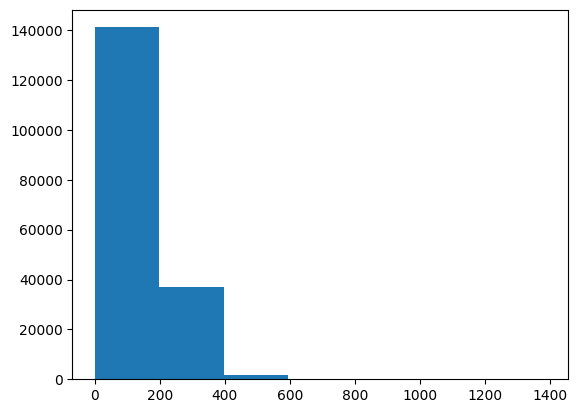

In [43]:
plt.hist(chars_len, bins=7)

In [44]:
# Find 95th percentile of char len
output_seq__char_len = int(np.percentile(chars_len, 95))

# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKENS  = len(alphabet) + 2 # Add UKN and out of vocab

output_seq__char_len, NUM_CHAR_TOKENS

(290, 70)

In [45]:
# Create char-level token vectorizer
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                output_sequence_length=output_seq__char_len,
                                                # standardize=None,
                                                name="char_vectorizer")

# Adapt char vectorizer
char_vectorizer.adapt(train_chars)

# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()

print(f"Vocab size : {len(char_vocab)}")
print(f"5 Most common chars: {char_vocab[:5]}")
print(f"5 Least common chars: {char_vocab[-5]}")

Vocab size : 28
5 Most common chars: ['', '[UNK]', 'e', 't', 'i']
5 Least common chars: k


In [46]:
# Test out char vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"Length of random_train_char: {len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i s r c t n @   .
Length of random_train_char: 17
Vectorized chars:
[[ 4  9  8 11  3  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
Length of vectoriz

In [47]:
# Character-level embedding
CHAR_EMBEDDING_DIM = 25 # From paper
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim=CHAR_EMBEDDING_DIM,
                                  mask_zero=True,
                                  name="char_embedding")

# Test it out
char_embed_ex = char_embedding(char_vectorizer([random_train_chars]))
print(f"Charified text:\n{random_train_chars}")
print(f"Embed char:\n{char_embed_ex}")
print(f"Shape of char embedding: {char_embed_ex.shape}")

Charified text:
i s r c t n @   .
Embed char:
[[[ 0.0201342  -0.0087171  -0.01315393 ... -0.04409757  0.00137851
   -0.00745809]
  [-0.02505921  0.02456291 -0.04825332 ... -0.04141158 -0.00554652
    0.04704363]
  [-0.03001837  0.04658902 -0.04074645 ...  0.01220395 -0.01411195
   -0.02343317]
  ...
  [ 0.00225099  0.00997311 -0.02314873 ...  0.00583038  0.04716573
    0.03980066]
  [ 0.00225099  0.00997311 -0.02314873 ...  0.00583038  0.04716573
    0.03980066]
  [ 0.00225099  0.00997311 -0.02314873 ...  0.00583038  0.04716573
    0.03980066]]]
Shape of char embedding: (1, 290, 25)


### Create the model

In [48]:
# Create the model
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation="softmax", name="output_layer")(x)

model_3 = tf.keras.Model(inputs, outputs, name ="model_3")
model_3_MHF = MHF(img_shape=None, model=model_3, class_names=[])

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch= int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps= int(0.1*len(val_char_dataset)))

model_3.summary()

Epoch 1/3


2023-08-05 08:46:24.594288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180040,5]
	 [[{{node Placeholder/_1}}]]


545/562 [============================>.] - ETA: 0s - loss: 1.2588 - accuracy: 0.4915

2023-08-05 08:46:27.182380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [30212,5]
	 [[{{node Placeholder/_1}}]]


562/562 [==============================] - 3s 4ms/step - loss: 1.2519 - accuracy: 0.4943 - val_loss: 1.0285 - val_accuracy: 0.5898
Epoch 2/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9981 - accuracy: 0.5989 - val_loss: 0.9417 - val_accuracy: 0.6233
Epoch 3/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9198 - accuracy: 0.6369 - val_loss: 0.8695 - val_accuracy: 0.6619
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                          

### Make predictions

In [49]:
model_3_preds_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)

945/945 [==============================] - 1s 1ms/step


### Evaluate the model

In [50]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.8841 - accuracy: 0.6560


[0.884109377861023, 0.655997633934021]

In [51]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

{'accuracy': 65.59976168409904,
 'precision': 0.6497345357982881,
 'recall': 0.6559976168409903,
 'f1': 0.6456196381781054}

## `model_4` token embeddings + character embeddings

### Create the model

2023-08-05 08:46:33.965707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

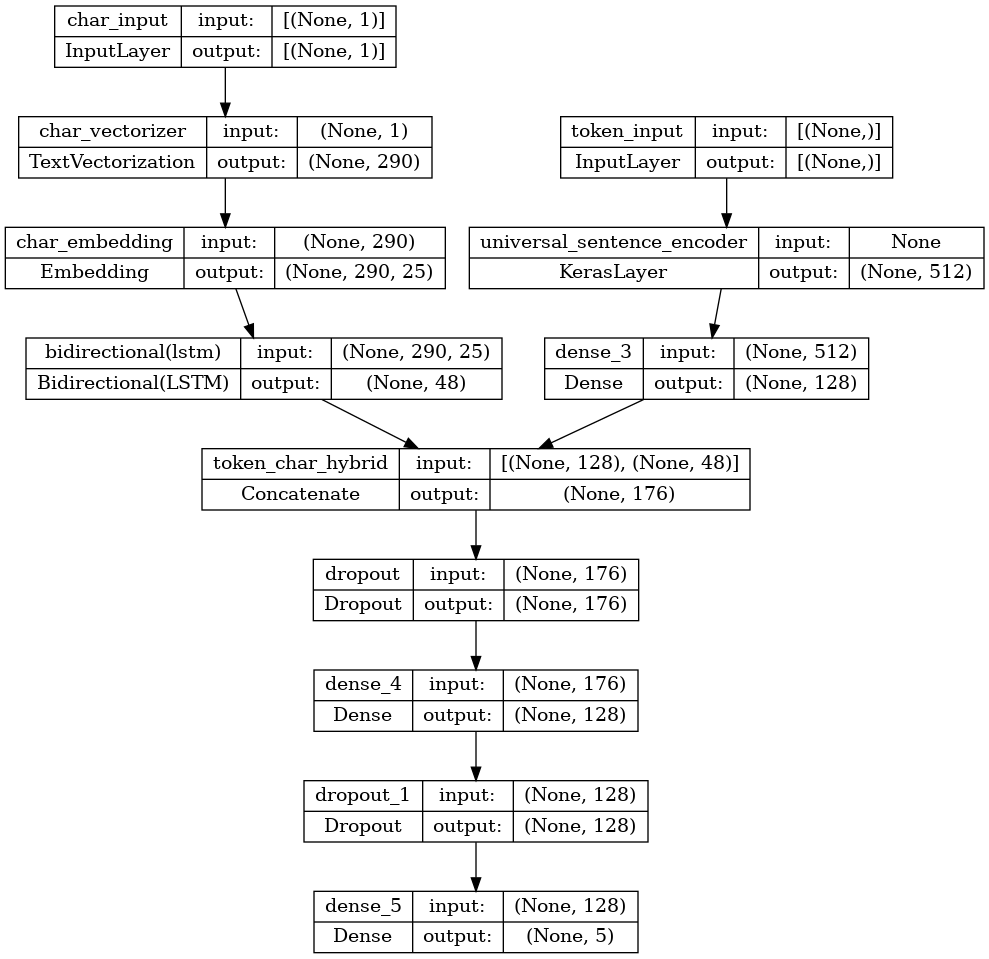

In [52]:
# Create the token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# Create a character-level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Concatenate token and char models (hybrid token embeddding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                   char_model.output])
# Create output layers with dropout as in the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Create model
model_4 =tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer, name="model_4")

model_4.summary()

# Plot the model
plot_model(model_4, show_shapes=True)

In [53]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Create TF Datasets
train_combined_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_combined_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_combined_dataset = tf.data.Dataset.zip((train_combined_data, train_combined_labels))
train_combined_dataset = train_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_combined_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_combined_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_combined_dataset = tf.data.Dataset.zip((val_combined_data, val_combined_labels))
val_combined_dataset = val_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_combined_data = tf.data.Dataset.from_tensor_slices((test_sentencess, test_chars))
test_combined_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_combined_dataset = tf.data.Dataset.zip((test_combined_data, test_combined_labels))
test_combined_dataset = test_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
# Fit the model
model_4_history = model_4.fit(train_combined_dataset,
                              steps_per_epoch=int(0.1*len(train_combined_dataset)),
                              epochs=3,
                              validation_data=val_combined_dataset,
                              validation_steps=int(0.1*len(val_combined_dataset)))

Epoch 1/3


2023-08-05 08:46:35.868414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [180040,5]
	 [[{{node Placeholder/_3}}]]
2023-08-05 08:46:37.376711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-05 08:46:38.898545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for

560/562 [============================>.] - ETA: 0s - loss: 0.9825 - accuracy: 0.6041

2023-08-05 08:46:51.118386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [30212,5]
	 [[{{node Placeholder/_3}}]]


562/562 [==============================] - 17s 23ms/step - loss: 0.9811 - accuracy: 0.6048 - val_loss: 0.7820 - val_accuracy: 0.6965
Epoch 2/3
562/562 [==============================] - 11s 20ms/step - loss: 0.8095 - accuracy: 0.6908 - val_loss: 0.7191 - val_accuracy: 0.7294
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7751 - accuracy: 0.7050 - val_loss: 0.6963 - val_accuracy: 0.7317


### Make predictions

In [55]:
model_4_preds_probs = model_4.predict(val_combined_dataset)
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)

945/945 [==============================] - 9s 8ms/step


### Evaluate the model

In [56]:
model_4.evaluate(val_combined_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.7007 - accuracy: 0.7320


[0.7007144689559937, 0.7319608330726624]

In [57]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 73.19608102740632,
 'precision': 0.7335032565930963,
 'recall': 0.7319608102740632,
 'f1': 0.7288739467688639}

## `model_5` token embeddings + character embeddings + positional embeddings

### Prepare positional/feature embedings data.

In [58]:
# Any engineered features used to train a model MSUT be available at test time.
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [59]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

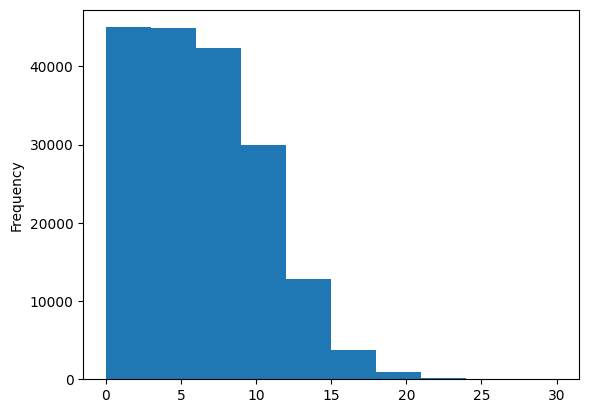

In [60]:
train_df.line_number.plot.hist()

In [61]:
# Create one-hot encoded tensors of the line number column to avoid the model thinking that line 4 is larger than 2
line_number_95p = int(np.percentile(train_df.line_number, 95))

train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_95p)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=line_number_95p)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_95p)

train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 13), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 13]))

In [62]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

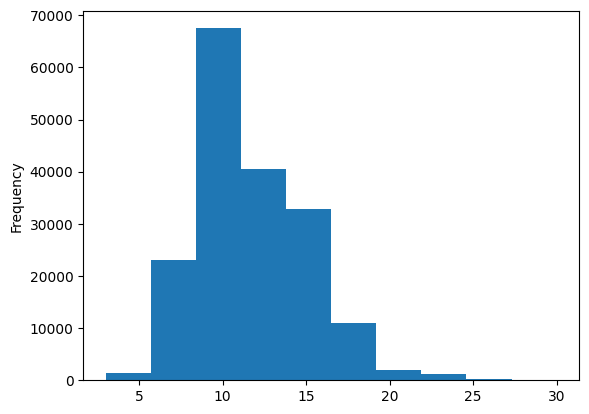

In [63]:
train_df["total_lines"].plot.hist()

In [64]:
total_lines_95p = int(np.percentile(train_df.total_lines, 95))

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_lines_95p)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=total_lines_95p)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_lines_95p)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 TensorShape([180040,

### Create the model

2023-08-05 08:47:31.423565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

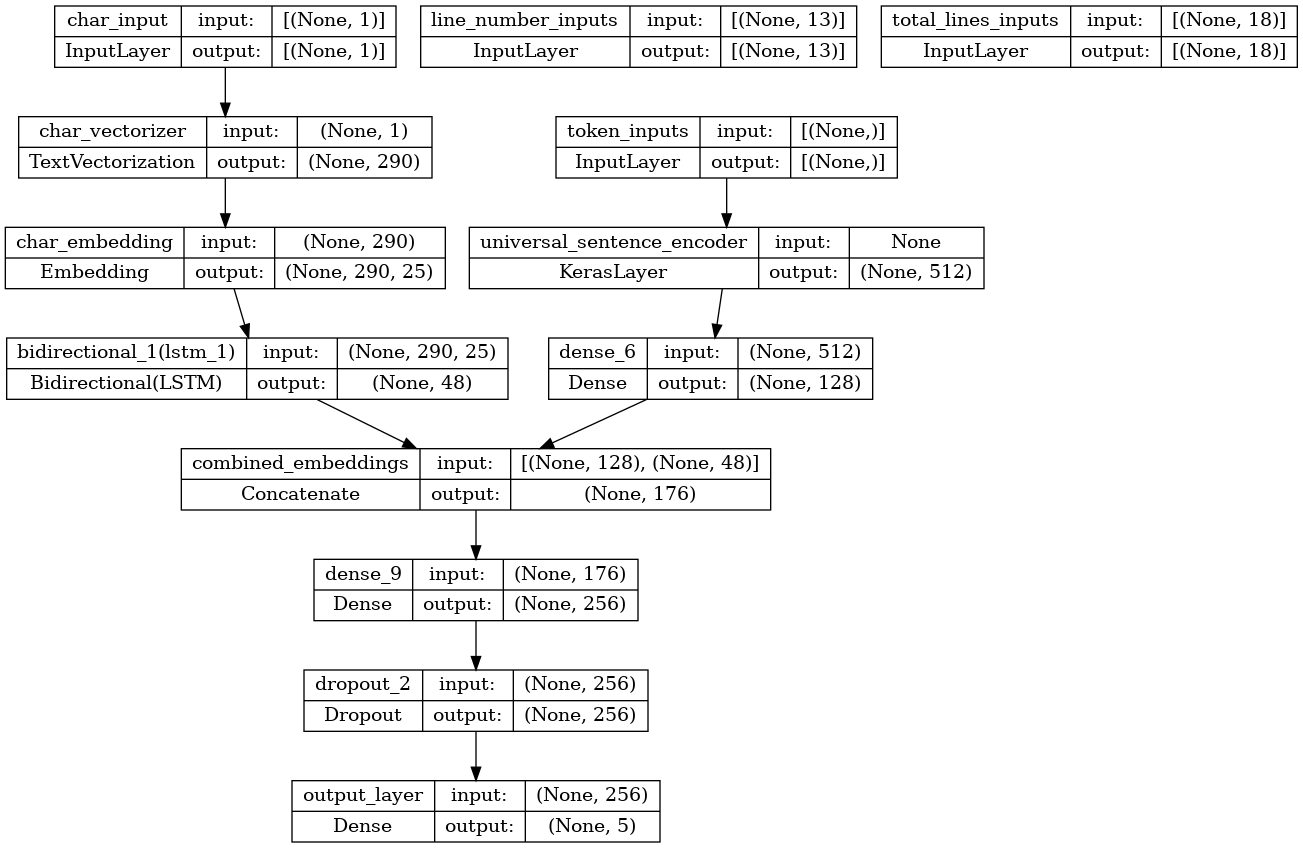

In [65]:
# Create a token-level model
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Create a character-level model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Create a positional embedding for line_number
line_number_inputs = layers.Input(shape=(line_number_95p,), dtype="float32", name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Create a positional embedding for total_lines
total_lines_inputs = layers.Input(shape=(total_lines_95p,), dtype="float32", name="total_lines_inputs")
x = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, x)

# Concatenate token-level and character-level outputs
combined_embeddings = layers.Concatenate(name="combined_embeddings")(
    [token_model.output, char_model.output])

# Drop out the combined embeddings output
x = layers.Dense(256, activation="relu")(combined_embeddings)
x = layers.Dropout(0.5)(x)

# Concatenate all outputs
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")(
                                                   [line_number_model.output,
                                                   total_lines_model.output,
                                                   x])
# Create an output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Create the training model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer)

# Compile the model, label smoothing helps to prevent overfitting.
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

# Plot the model
plot_model(model_5, show_shapes=True)

In [66]:
# Create TF Datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                           train_total_lines_one_hot,
                                                           train_sentences,
                                                           train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                         val_total_lines_one_hot,
                                                         val_sentences,
                                                         val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [67]:
# Fit the model
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3


2023-08-05 08:47:33.154922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [180040]
	 [[{{node Placeholder/_3}}]]
2023-08-05 08:47:34.326741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-05 08:47:35.744032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for p

562/562 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.6606

2023-08-05 08:47:55.050048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [30212,13]
	 [[{{node Placeholder/_0}}]]


562/562 [==============================] - 24s 36ms/step - loss: 1.1754 - accuracy: 0.6606 - val_loss: 1.0940 - val_accuracy: 0.7261
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 1.0837 - accuracy: 0.7264 - val_loss: 1.0554 - val_accuracy: 0.7414
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 1.0687 - accuracy: 0.7367 - val_loss: 1.0404 - val_accuracy: 0.7600


### Make predictions

In [68]:
model_5_preds_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_preds_probs, axis=1)

945/945 [==============================] - 8s 7ms/step


### Evaluate the model

In [69]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 75.32768436382894,
 'precision': 0.751347049813833,
 'recall': 0.7532768436382894,
 'f1': 0.7509216515015622}

## `model_6` `model_5` on full data.

### Prepare positional/feature embedings data.

In [115]:
# Any engineered features used to train a model MSUT be available at test time.
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [116]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

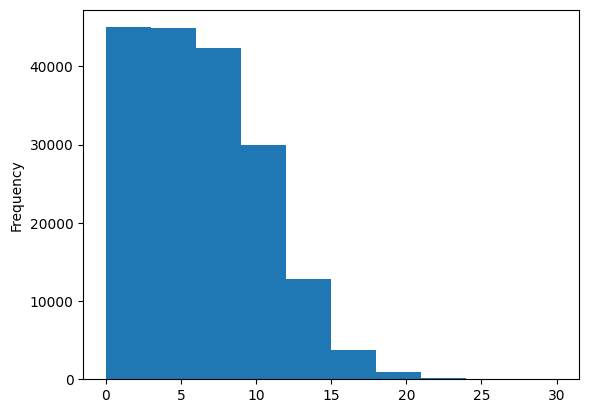

In [117]:
train_df.line_number.plot.hist()

In [126]:
# Create one-hot encoded tensors of the line number column to avoid the model thinking that line 4 is larger than 2
line_number_95p = int(np.percentile(train_df.line_number, 95))

train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_95p)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=line_number_95p)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_95p)

train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 13), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 13]))

In [119]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

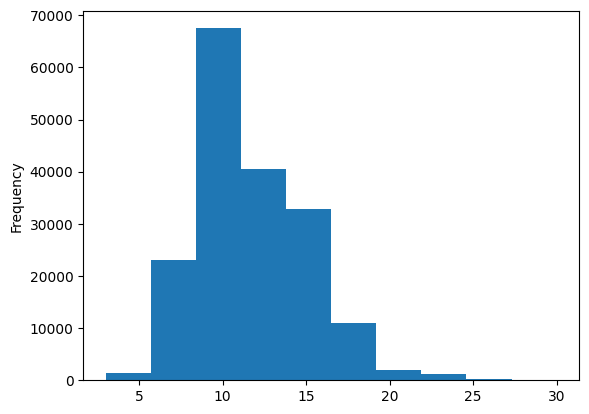

In [120]:
train_df["total_lines"].plot.hist()

In [121]:
total_lines_95p = int(np.percentile(train_df.total_lines, 95))

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_lines_95p)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=total_lines_95p)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_lines_95p)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 18), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]], dtype=float32)>,
 TensorShape([180040,

### Create the model

2023-08-05 08:48:42.719606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

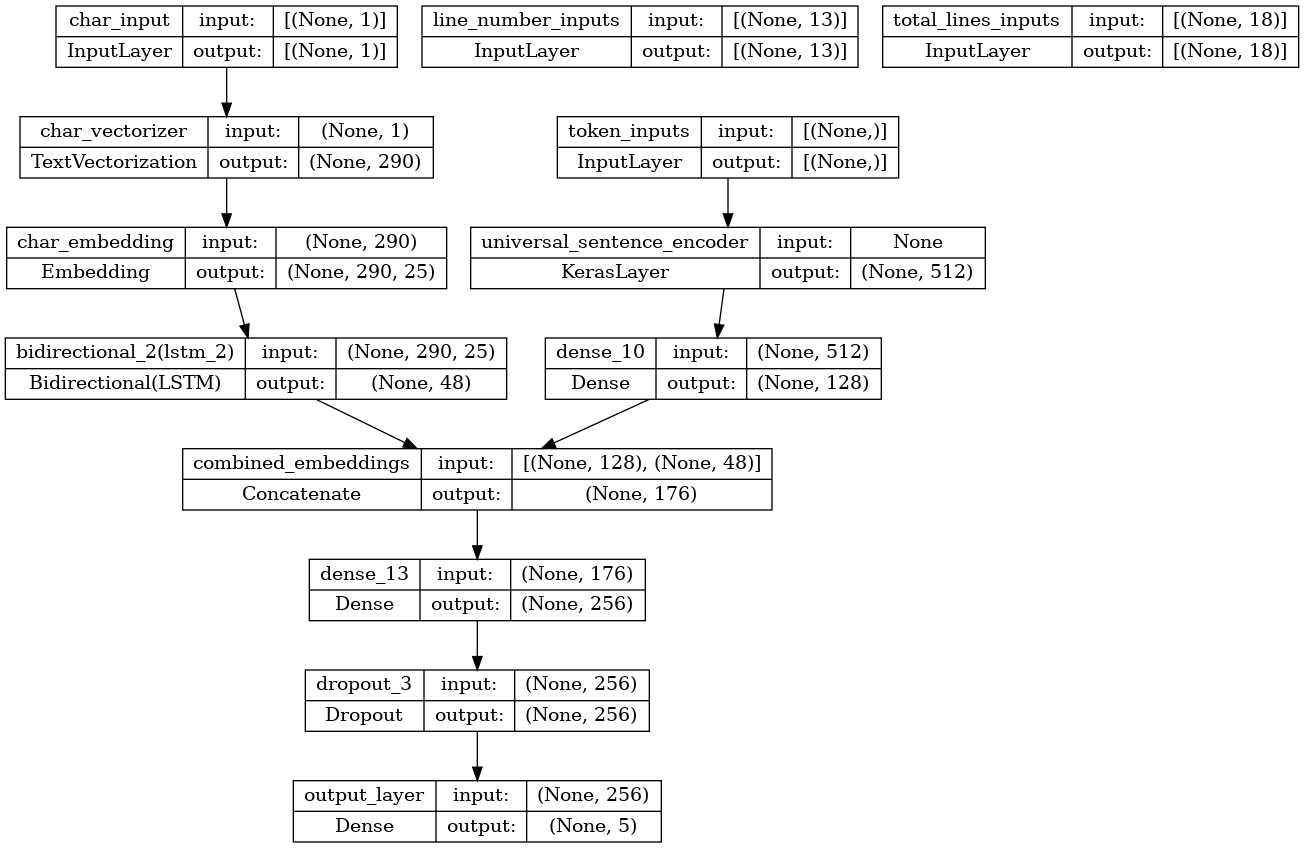

In [77]:
# Create a token-level model
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Create a character-level model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Create a positional embedding for line_number
line_number_inputs = layers.Input(shape=(line_number_95p,), dtype="float32", name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Create a positional embedding for total_lines
total_lines_inputs = layers.Input(shape=(total_lines_95p,), dtype="float32", name="total_lines_inputs")
x = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, x)

# Concatenate token-level and character-level outputs
combined_embeddings = layers.Concatenate(name="combined_embeddings")(
    [token_model.output, char_model.output])

# Drop out the combined embeddings output
x = layers.Dense(256, activation="relu")(combined_embeddings)
x = layers.Dropout(0.5)(x)

# Concatenate all outputs
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")(
                                                   [line_number_model.output,
                                                   total_lines_model.output,
                                                   x])
# Create an output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Create the training model
model_6 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer)

# Compile the model, label smoothing helps to prevent overfitting.
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

# Plot the model
plot_model(model_6, show_shapes=True)

In [122]:
# Create TF Datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                           train_total_lines_one_hot,
                                                           train_sentences,
                                                           train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                         val_total_lines_one_hot,
                                                         val_sentences,
                                                         val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [79]:
# Fit the model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

model_6_history = model_6.fit(train_char_token_pos_dataset,
                              epochs=30,
                              validation_data=val_char_token_pos_dataset,
                              callbacks=[early_stopping])

Epoch 1/30


2023-08-05 08:48:44.452648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [180040,18]
	 [[{{node Placeholder/_1}}]]
2023-08-05 08:48:45.630974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-08-05 08:48:47.075468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for

5627/5627 [==============================] - ETA: 0s - loss: 1.0594 - accuracy: 0.7430

2023-08-05 08:50:57.125937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [30212]
	 [[{{node Placeholder/_2}}]]


5627/5627 [==============================] - 143s 25ms/step - loss: 1.0594 - accuracy: 0.7430 - val_loss: 1.0065 - val_accuracy: 0.7732
Epoch 2/30
5627/5627 [==============================] - 115s 20ms/step - loss: 1.0078 - accuracy: 0.7795 - val_loss: 0.9914 - val_accuracy: 0.7840
Epoch 3/30
5627/5627 [==============================] - 114s 20ms/step - loss: 0.9887 - accuracy: 0.7934 - val_loss: 0.9850 - val_accuracy: 0.7884
Epoch 4/30
5627/5627 [==============================] - 111s 20ms/step - loss: 0.9751 - accuracy: 0.8045 - val_loss: 0.9831 - val_accuracy: 0.7901
Epoch 5/30
5627/5627 [==============================] - 109s 19ms/step - loss: 0.9652 - accuracy: 0.8113 - val_loss: 0.9820 - val_accuracy: 0.7933
Epoch 6/30
5627/5627 [==============================] - 109s 19ms/step - loss: 0.9569 - accuracy: 0.8169 - val_loss: 0.9822 - val_accuracy: 0.7924
Epoch 7/30
5627/5627 [==============================] - 111s 20ms/step - loss: 0.9500 - accuracy: 0.8233 - val_loss: 0.9816 - val

### Make predictions

In [80]:
model_6_preds_probs = model_6.predict(val_char_token_pos_dataset)
model_6_preds = tf.argmax(model_6_preds_probs, axis=1)

945/945 [==============================] - 9s 8ms/step


### Evaluate the model

In [81]:
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 79.27975638819012,
 'precision': 0.794017773729072,
 'recall': 0.7927975638819013,
 'f1': 0.7898388004194661}

## `model_7` loaded model from Google Storage

### Load model

In [82]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [ ]:
model_7 = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model/")

In [91]:
total_lines_95p = 20

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=total_lines_95p)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=total_lines_95p)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_lines_95p)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

# Create one-hot encoded tensors of the line number column to avoid the model thinking that line 4 is larger than 2
line_number_95p = 15

train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=line_number_95p)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=line_number_95p)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_95p)

train_line_number_one_hot[:10], train_line_number_one_hot.shape

# Create TF Datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                           train_total_lines_one_hot,
                                                           train_sentences,
                                                           train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                         val_total_lines_one_hot,
                                                         val_sentences,
                                                         val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [92]:
model_7.evaluate(val_char_token_pos_dataset)

2023-08-05 09:15:20.840244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [30212,15]
	 [[{{node Placeholder/_0}}]]
2023-08-05 09:15:20.996678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 09:15:20.997440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

945/945 [==============================] - 9s 8ms/step - loss: 0.9388 - accuracy: 0.8304


[0.9387755990028381, 0.8303984999656677]

## Compare models.

In [94]:
all_model_results = pd.DataFrame({"model_0":model_0_results,
                                 "model_1":model_1_results,
                                 "model_2":model_2_results,
                                 "model_3":model_3_results,
                                 "model_4":model_4_results,
                                 "model_5":model_5_results,
                                 "model_6":model_6_results})

all_model_results = all_model_results.transpose()

# Scale accuracy.
all_model_results["accuracy"] = all_model_results["accuracy"]/100

all_model_results

,accuracy,precision,recall,f1
model_0,0.721832,0.718647,0.721832,0.698925
model_1,0.783033,0.780447,0.783033,0.780668
model_2,0.715841,0.716196,0.715841,0.712626
model_3,0.655998,0.649735,0.655998,0.645620
model_4,0.731961,0.733503,0.731961,0.728874
model_5,0.753277,0.751347,0.753277,0.750922
model_6,0.792798,0.794018,0.792798,0.789839


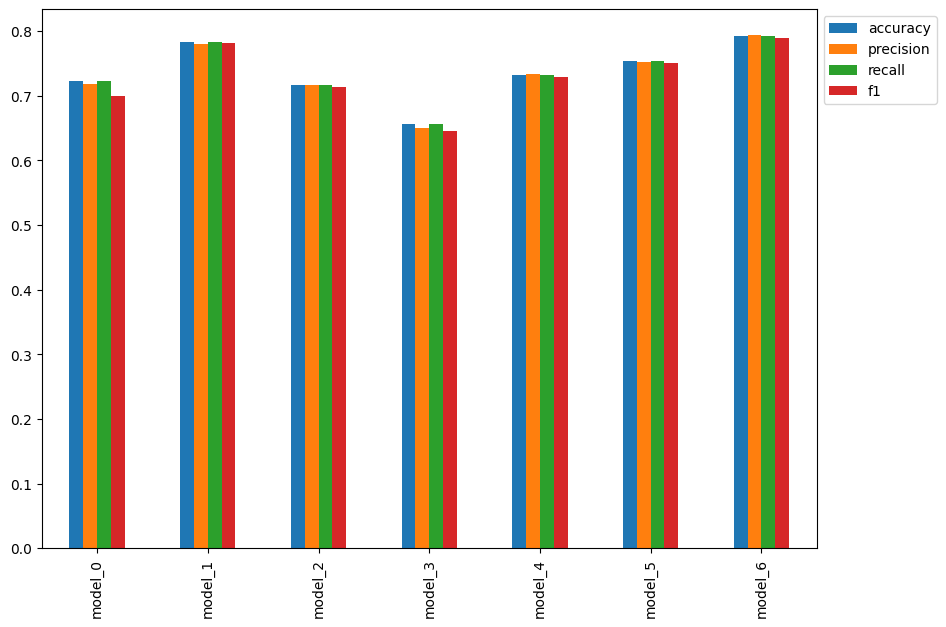

In [95]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

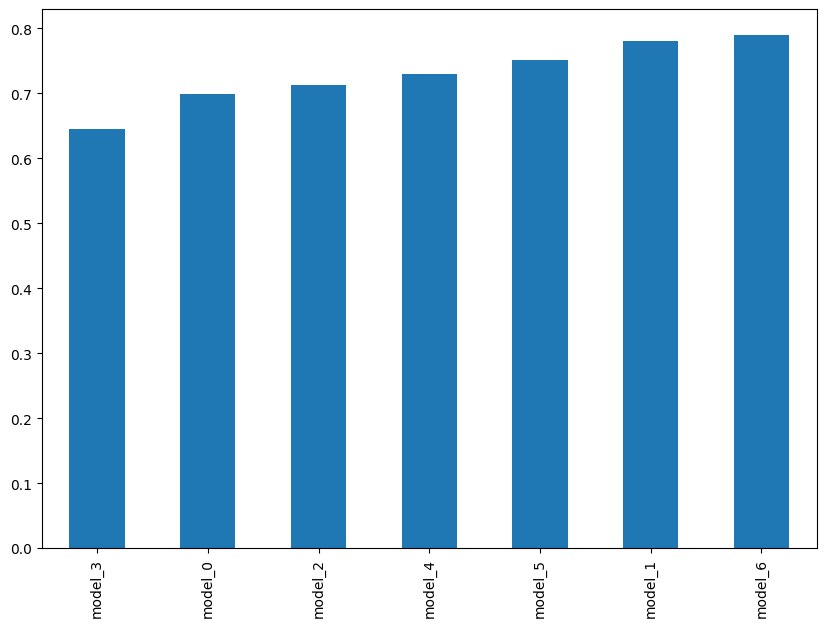

In [96]:
# Sort model results by F1-Score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar",figsize=(10,7))

## Test best model

### Prepare data

In [128]:
# Create one-hot encoded tensors of the line number column to avoid the model thinking that line 4 is larger than 2
line_number_95p = int(np.percentile(train_df.line_number, 95))
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=line_number_95p)

total_lines_95p = int(np.percentile(train_df.total_lines, 95))

test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=total_lines_95p)


# Create TF Datasets
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentencess,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Test

In [132]:
test_pred_probs = model_6.predict(test_char_token_pos_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 8s 8ms/step


In [133]:
test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
test_results

{'accuracy': 78.63945578231292,
 'precision': 0.785979765300759,
 'recall': 0.7863945578231293,
 'f1': 0.7831093954972032}

### Most wrong predictions

In [135]:
# Get class names per test prediction
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

CPU times: user 7.22 s, sys: 935 ms, total: 8.15 s
Wall time: 7.37 s


In [136]:
test_df

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8
...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17
30131,RESULTS,there were no statistically significant betwee...,14,17
30132,RESULTS,there was no significant association between s...,15,17
30133,RESULTS,no adverse effects were reported .,16,17


In [137]:
# Create a prediction, pred prob and correct columns
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,BACKGROUND,0.317479,True
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.275117,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.778406,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.809835,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.832853,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.834450,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.587176,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,BACKGROUND,0.495267,False
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.665655,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.632261,True


In [139]:
top_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)
top_wrong.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
8949,BACKGROUND,this is the first study designed to obtain con...,2,14,CONCLUSIONS,0.972546,False
8648,BACKGROUND,this is of public health importance as identif...,5,15,CONCLUSIONS,0.961903,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.961110,False
10943,RESULTS,"in male kestrels , butorphanol did not signifi...",5,12,CONCLUSIONS,0.960954,False
950,METHODS,"of the @ patients included in the study , @ an...",2,10,RESULTS,0.954020,False
28079,METHODS,a total of @ patients were randomized .,2,9,RESULTS,0.947996,False
19839,OBJECTIVE,once-daily losartan reduces bp in a dose-depen...,0,13,CONCLUSIONS,0.946513,False
14487,BACKGROUND,vitamin d insufficiency associates with suscep...,1,12,CONCLUSIONS,0.946310,False
7968,BACKGROUND,dpbrn hygienists internet quality improvement ...,12,12,CONCLUSIONS,0.945425,False
18459,BACKGROUND,training with the focus on task time improveme...,1,12,CONCLUSIONS,0.940902,False


## Save best model.

In [ ]:
model_6.save("skimlit_model")

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_model")

In [124]:
loaded_model_preds_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_preds_probs, axis=1)
loaded_model_results = calculate_results(val_labels_encoded, loaded_model_preds)
loaded_model_results, model_6_results

2023-08-05 09:17:36.838762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [30212]
	 [[{{node Placeholder/_2}}]]


945/945 [==============================] - 9s 8ms/step


({'accuracy': 79.27975638819012,
  'precision': 0.794017773729072,
  'recall': 0.7927975638819013,
  'f1': 0.7898388004194661},
 {'accuracy': 79.27975638819012,
  'precision': 0.794017773729072,
  'recall': 0.7927975638819013,
  'f1': 0.7898388004194661})

In [125]:
np.isclose(loaded_model_results["accuracy"], model_6_results["accuracy"])

True

## Make example predictions

### Get data.
Download some abstracts from github.

In [140]:

import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

/bin/bash: /home/santiagorg2401/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-08-05 09:36:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-08-05 09:36:42 (45.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [142]:
abstracts_df = pd.DataFrame(example_abstracts)
abstracts_df

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [149]:
# Use spaCy to preprocess the data according to model architecture.
from spacy.lang.en import English
nlp = English()

# Split the abstracts into lines
sentencizer = nlp.add_pipe("sentencizer")
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines[:5]

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).']

In [152]:
total_lines_in_sample = len(abstract_lines)

# Format data into dictionaries
sample_lines = []
for i,line in enumerate(abstract_lines):
  sample_dict={}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines[:5]

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7}]

In [155]:
# Encode data.
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=line_number_95p)

test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=total_lines_95p)

# Split lines into characters.
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

In [195]:
# Make predictions
%%time
test_abstract_pred_probs = model_6.predict(x=(test_abstract_line_numbers_one_hot,
                                              test_abstract_total_lines_one_hot,
                                              tf.constant(abstract_lines),
                                              tf.constant(abstract_chars)))

test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds_classes = [label_encoder.classes_[i] for i in test_abstract_preds]


1/1 [==============================] - 0s 17ms/step
CPU times: user 43 ms, sys: 11.1 ms, total: 54.1 ms
Wall time: 43.4 ms


In [197]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_preds_classes[i]}: {line}")

BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
